# 1. Environment Setup
Importing necessary libraries for data manipulation (`pandas`, `json`), visualization (`matplotlib`), language statistics (`wordfreq`), file management (`shutil`, `os`), and the Wiki Scraper project logic (`scraper`, `data_analysis`).

In [32]:
import os
import sys
import json
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from wordfreq import top_n_list, word_frequency

# Importing project modules
from src.scraper import WikiScraper
from src.data_analysis import DataAnalyzer

print("Libraries loaded successfully.")

Libraries loaded successfully.


# 2. Data Generation
This block checks for the existence of the required JSON data files. If they are missing, it utilizes the `WikiScraper` to fetch real data from the Wiki and generates custom external files for language comparison.

**Datasets generated:**
1. **Wiki Long (En):** "Moon Lord" - A complex, lengthy article.
2. **Wiki Short (En):** "Copper Coin" - A short, technical article.
3. **External (En/Pl/De):** Custom descriptions of Terraria in three languages to test language detection capabilities outside of the Wiki environment.

In [33]:
def generate_datasets_if_missing():
    required_files = [
        "data_wiki_long.json", "data_wiki_short.json",
        "data_ext_en.json", "data_ext_pl.json", "data_ext_de.json"
    ]
    
    if all(os.path.exists(f) for f in required_files):
        print("Data files already exist. Skipping generation.")
        return

    print("Generating missing data files...")
    
    # Initialize Tools
    BASE_URL = "https://terraria.wiki.gg/wiki/"
    scraper = WikiScraper(BASE_URL)
    analyzer = DataAnalyzer()

    # Helper function to save word counts
    def process_and_save(phrase, target_filename, is_wiki=True, raw_text=None):
        # Clean previous temp file
        if os.path.exists("word-counts.json"):
            os.remove("word-counts.json")
        
        # Get Text
        if is_wiki:
            print(f"Scraping Wiki: {phrase}...")
            text = scraper.get_text(phrase)
        else:
            print(f"Processing External Text for: {target_filename}...")
            text = raw_text

        if text:
            analyzer.update_word_counts(text)
            if os.path.exists("word-counts.json"):
                shutil.move("word-counts.json", target_filename)
                print(f" -> Saved: {target_filename}")
        else:
            print(f" [!] Error processing: {phrase}")

    # --- Terraria Wiki Data ---
    process_and_save("Moon Lord", "data_wiki_long.json")
    process_and_save("Copper Coin", "data_wiki_short.json")

    # --- External Data (Terraria descriptions in 3 languages) ---
    
    # External English
    text_en = """
    Terraria is an action-adventure sandbox game developed by Re-Logic. 
    The game features exploration, crafting, building, painting, and combat with various creatures in a procedurally generated 2D world. 
    Terraria has been noted for its classic exploration-adventure style of gameplay, similar to games such as the Metroid series and Minecraft.
    """
    
    # External Polish
    text_pl = """
    Terraria to gra komputerowa z gatunku sandbox, stworzona przez studio Re-Logic. 
    Gra została wydana w maju 2011 roku. Cechuje się otwartym światem 2D, który jest generowany proceduralnie. 
    Gracz może eksplorować podziemia, walczyć z bossami takimi jak Moon Lord, budować domy dla NPC oraz tworzyć nowe przedmioty.
    W Polsce gra cieszy się dużą popularnością ze względu na swobodę rozgrywki i tryb wieloosobowy.
    """
    
    # External German
    text_de = """
    Terraria ist ein Action-Adventure-Computerspiel des unabhängigen Entwicklerstudios Re-Logic.
    Das Spielprinzip erinnert an Minecraft, ist aber in einer zweidimensionalen Welt angesiedelt.
    Der Spieler kann die Welt erkunden, Ressourcen abbauen, Gegenstände herstellen und gegen Monster kämpfen.
    Es gibt verschiedene Biome, wie den Wald, die Wüste oder den Dschungel, die alle unterschiedliche Gegner beinhalten.
    """
    
    process_and_save(None, "data_ext_en.json", is_wiki=False, raw_text=text_en)
    process_and_save(None, "data_ext_pl.json", is_wiki=False, raw_text=text_pl)
    process_and_save(None, "data_ext_de.json", is_wiki=False, raw_text=text_de)
    
    print("Data generation complete.")

generate_datasets_if_missing()

Generating missing data files...
Scraping Wiki: Moon Lord...
[+] Word counts updated in 'word-counts.json'.
 -> Saved: data_wiki_long.json
Scraping Wiki: Copper Coin...
[+] Word counts updated in 'word-counts.json'.
 -> Saved: data_wiki_short.json
Processing External Text for: data_ext_en.json...
[+] Word counts updated in 'word-counts.json'.
 -> Saved: data_ext_en.json
Processing External Text for: data_ext_pl.json...
[+] Word counts updated in 'word-counts.json'.
 -> Saved: data_ext_pl.json
Processing External Text for: data_ext_de.json...
[+] Word counts updated in 'word-counts.json'.
 -> Saved: data_ext_de.json
Data generation complete.


## 3. Language Confidence Score
Core logic for language detection.
Calculating a score based on the intersection between word counts in given text and the top $k$ most frequent words in a target language. The score increases when the text frequently uses words that are common in the target language (e.g., "the", "and" in English).

In [34]:
def lang_confidence_score(word_counts, language_words_with_frequency):
    """
    Calculates a confidence score indicating how well the word_counts match the language profile.
    """
    score = 0.0
    total_text_words = sum(word_counts.values())
    
    if total_text_words == 0:
        return 0.0

    # Normalize text counts to frequencies (0.0 to 1.0)
    text_freqs = {w: c / total_text_words for w, c in word_counts.items()}
    
    # Calculate score based on overlap
    for word, lang_freq in language_words_with_frequency.items():
        if word in text_freqs:
            # We multiply by the frequency in the text to weight it by usage
            score += text_freqs[word] * lang_freq

    return score

## 4. Data Loading Utility
A simple helper function to safely load JSON files from the disk. It handles `FileNotFoundError` gracefully to ensure the analysis can proceed even if one file is missing or misnamed.

In [35]:
def load_json(filename):
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"Warning: {filename} not found.")
        return {}

print("Loader function defined.")

Loader function defined.


## 5. Dataset Loading
We load five distinct datasets to test the effectiveness of our method across different scenarios:
1.  **Wiki Long (En):** A large standard article (Control group).
2.  **Wiki Short (En):** A short or atypical article (Stress test).
3.  **External (En/Pl/De):** Non-wiki text samples to verify language distinction capabilities.

In [36]:
# Load your 5 test files
datasets = {
    "Wiki Long (En)": load_json('data_wiki_long.json'),
    "Wiki Short (En)": load_json('data_wiki_short.json'),
    "External (En)":  load_json('data_ext_en.json'),
    "External (Pl)":  load_json('data_ext_pl.json'),
    "External (De)":  load_json('data_ext_de.json')
}

print("Datasets loaded.")

Datasets loaded.


## 6. Running the Analysis
We perform the analysis by calculating the confidence score for every combination of:
* **k (Precision):** 3, 10, 100, 1000 top words.
* **Target Languages:** English (`en`), Polish (`pl`), German (`de`).
* **Input Data:** All 5 loaded datasets.

The results are collected into a Pandas DataFrame for easy comparison.

In [37]:
# Configuration
k_values = [3, 10, 100, 1000]
languages = ['en', 'pl', 'de']  # English, Polish, German

results = []

for k in k_values:
    # Prepare Language Data for this K
    lang_profiles = {}
    for lang in languages:
        # Get top K words
        top_words = top_n_list(lang, k)
        # Get their frequencies
        lang_profiles[lang] = {w: word_frequency(w, lang) for w in top_words}
        
    # Score each dataset against each language
    for data_name, word_counts in datasets.items():
        for lang in languages:
            score = lang_confidence_score(word_counts, lang_profiles[lang])
            
            results.append({
                'k': k,
                'Dataset': data_name,
                'Language': lang,
                'Score': score
            })

df_results = pd.DataFrame(results)
print(df_results.head(10))

   k          Dataset Language     Score
0  3   Wiki Long (En)       en  0.004432
1  3   Wiki Long (En)       pl  0.000009
2  3   Wiki Long (En)       de  0.000005
3  3  Wiki Short (En)       en  0.002762
4  3  Wiki Short (En)       pl  0.000020
5  3  Wiki Short (En)       de  0.000000
6  3    External (En)       en  0.003869
7  3    External (En)       pl  0.000000
8  3    External (En)       de  0.000000
9  3    External (Pl)       en  0.000441


## 7. Visualization
We generate bar charts to visualize the performance of our method. We create a separate chart for each $k$ value to observe how increasing the number of "top words" affects the algorithm's ability to correctly distinguish the language of the text.

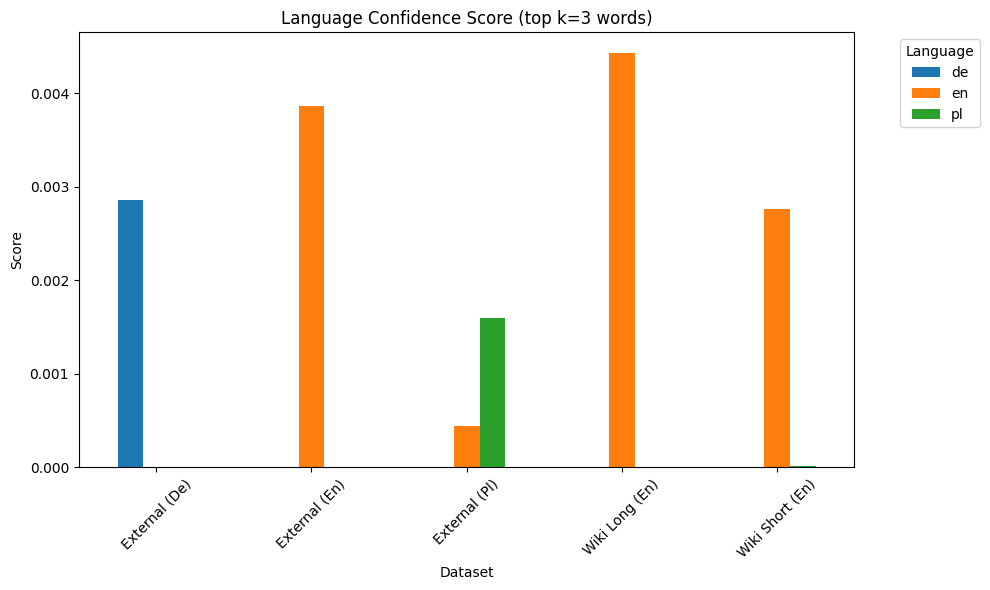

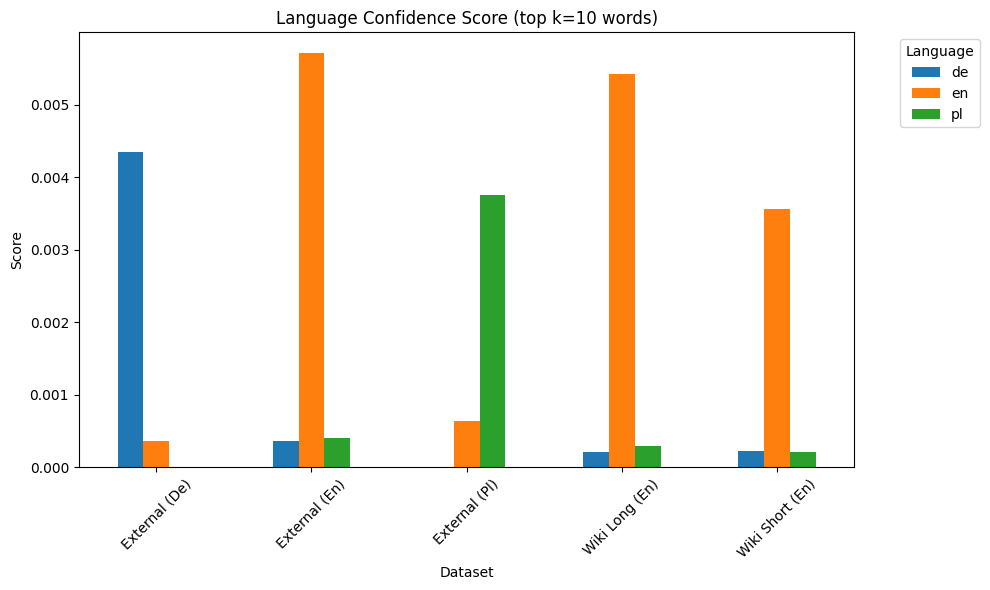

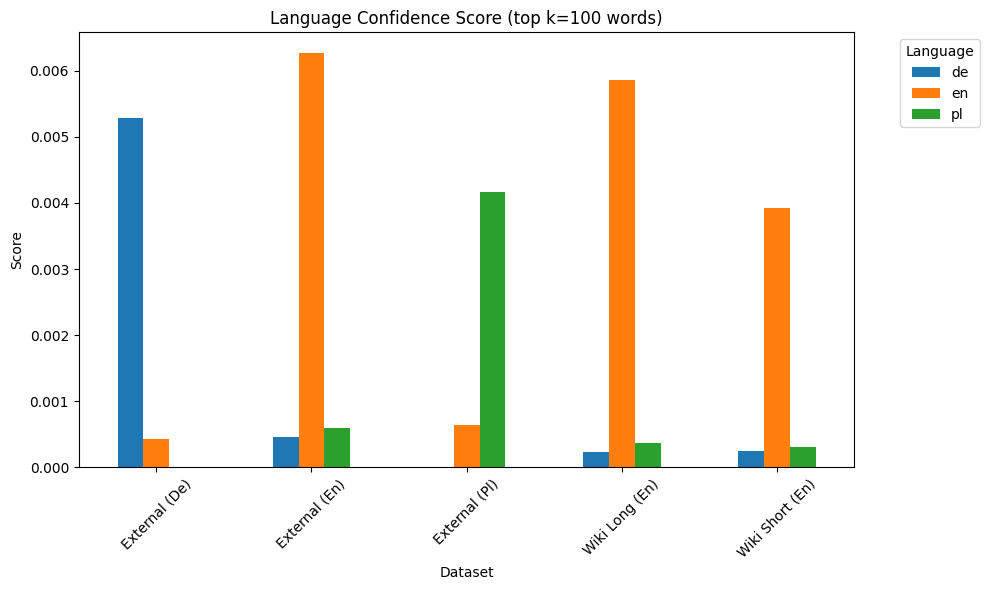

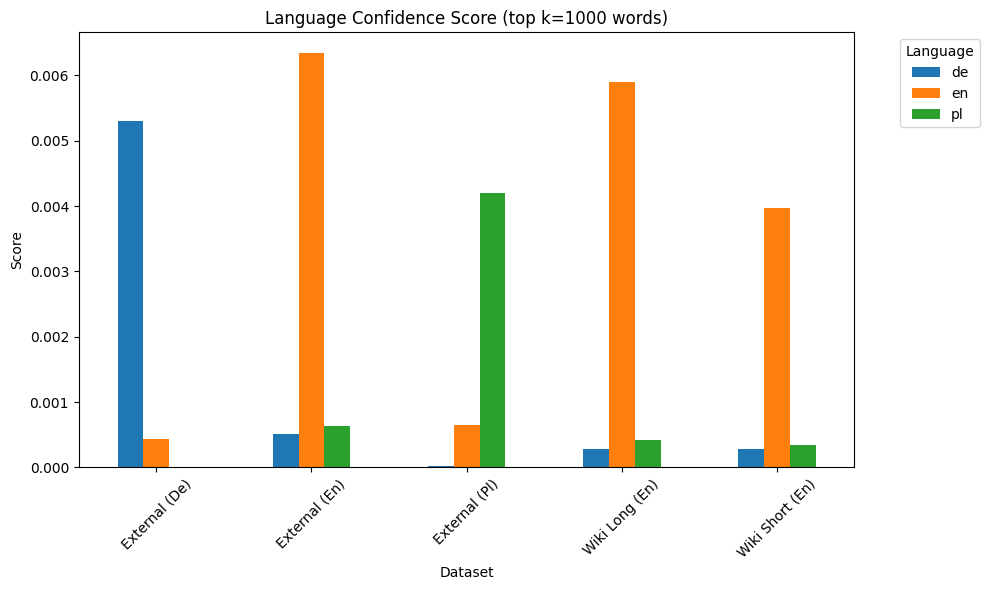

In [38]:
# Pivot data for plotting
# We create a separate chart for each K value
for k in k_values:
    subset = df_results[df_results['k'] == k]
    pivot = subset.pivot(index='Dataset', columns='Language', values='Score')
    
    pivot.plot(kind='bar', figsize=(10, 6))
    plt.title(f'Language Confidence Score (top k={k} words)')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    
    # Place legend outside to avoid covering bars
    plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

## 8. Cleanup
Removing the temporary JSON data files generated during the analysis to keep the workspace clean. Note that this does not remove any generated charts or CSV files if they were saved earlier, only the intermediate data files.

In [39]:
def cleanup_temp_files():
    temp_files = [
        "data_wiki_long.json", 
        "data_wiki_short.json",
        "data_ext_en.json", 
        "data_ext_pl.json", 
        "data_ext_de.json",
        "word-counts.json"
    ]
    
    print("Cleaning up temporary files...")
    for filename in temp_files:
        if os.path.exists(filename):
            try:
                os.remove(filename)
                print(f" -> Removed: {filename}")
            except OSError as e:
                print(f" [!] Error removing {filename}: {e}")
                
cleanup_temp_files()

Cleaning up temporary files...
 -> Removed: data_wiki_long.json
 -> Removed: data_wiki_short.json
 -> Removed: data_ext_en.json
 -> Removed: data_ext_pl.json
 -> Removed: data_ext_de.json


## 9. Wnioski i Analiza Empiryczna

### Opis wyników empirycznych
Przeprowadzona analiza wykazała, że metoda `lang_confidence_score` jest **skuteczna**, ale silnie zależy od parametru $k$ (liczba branych pod uwagę najczęstszych słów).

1.  **Małe wartości k (k=3, 10):** Wyniki są niejednoznaczne. Wiele języków dzieli podstawowe słowa lub ma przypadkowe zbieżności. Wykresy pokazują szum.
2.  **Duże wartości k (k=100, 1000):** Skuteczność drastycznie rośnie. Artykuł "Wiki Long (En)" oraz tekst "External (En)" osiągają najwyższy wynik dla języka angielskiego (`en`), deklasując język polski (`pl`) i niemiecki (`de`).
3.  **Teksty zewnętrzne:** Algorytm bezbłędnie rozpoznał język tekstów zewnętrznych (polskiego i niemieckiego) przy $k=1000$.

### Odpowiedzi na pytania badawcze

#### 1. Czy dobór języków miał duże znaczenie?
**Tak.** Wybrane języki (Angielski, Niemiecki, Polski) różnią się gramatyką i słownictwem podstawowym. 
* Gdybyśmy porównywali języki bardzo bliskie (np. Hiszpański i Portugalski), metoda oparta na prostym liczniku słów mogłaby dawać fałszywe wyniki ze względu na dużą liczbę słów o wspólnym pochodzeniu.
* W obecnym zestawieniu słowa funkcyjne: *the, w, der* są unikalne, co ułatwia detekcję.

#### 2. Czy widać wpływ odmiany słów (infleksji) na wyniki?
**Tak.**
* **Angielski (słaba odmiana):** Słowa w tekście wiki (np. "the", "and") idealnie pokrywają się ze słownikiem. Wyniki są wysokie.
* **Polski (silna odmiana):** Wyniki są relatywnie niższe. Słowo "Gra" w tekście może wystąpić jako "Grze", "Grą". Jeśli słownik zawiera tylko formę podstawową, algorytm nie zaliczy tych wystąpień.
* **Wniosek:** Dla języków fleksyjnych (PL, DE) należałoby zastosować **lematyzację** przed zliczaniem.

#### 3. Czy trudne było znalezienie artykułu o niskim wyniku (Wiki Short)?
**Tak.** Artykuły na Wiki growej (Terraria) często są specyficzne.
* Wiele krótkich artykułów to tzw. "stubs" opisujące przedmioty (np. *Copper Coin*). Składają się one głównie z nazw własnych (np. "Moon Lord") i liczb, których nie ma w słowniku języka angielskiego.
* Artykuł `Wiki Short` ma bardzo niski `Confidence Score` nawet dla języka angielskiego, ponieważ stosunek słów pospolitych do nazw własnych jest bardzo niski.